In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('full_data.csv')

#Checking for NULL values if any
print(data.isnull().values.ravel().sum())

#Checking Class Imbalance
print(data['apply'].value_counts())

0
0    1092887
1     108003
Name: apply, dtype: int64


In [2]:
# Convert city_match to category since its range [-1, 0, 1] might affect classification 
import datetime as dt

data['search_date_pacific'] = pd.to_datetime(data['search_date_pacific'], format = '%Y-%m-%d').dt.date
data['city_match'] = data['city_match'].astype('category')
oneHotEncoding = pd.get_dummies(data['city_match'], prefix = 'city_match', drop_first = True)
data = pd.concat([data, oneHotEncoding], axis = 1)
data = data.drop('city_match', axis = 1)
data_train = data[data['search_date_pacific'] < dt.date(2018,1,27)]
data_test = data[data['search_date_pacific'] > dt.date(2018,1,26)]

In [3]:
days = []
jobApplied = []
jobRejected = []

for i in range(1, 31):
    days.append(i)
    
for day in days:
    daywise_data = data[(data['job_age_days'] == day)]
    jobApplied.append(daywise_data['apply'].value_counts()[1])
    jobRejected.append(daywise_data['apply'].value_counts()[0])

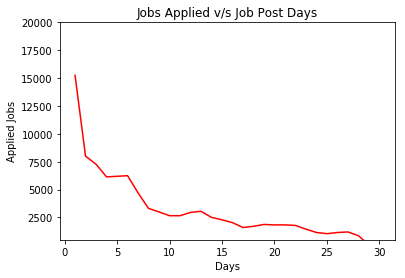

In [5]:
import matplotlib.pyplot as plt

plt.plot(days, jobApplied, color = 'r')
plt.ylim(500, 20000)
plt.xlabel('Days')
plt.ylabel('Applied Jobs')
plt.title('Jobs Applied v/s Job Post Days')
plt.show()


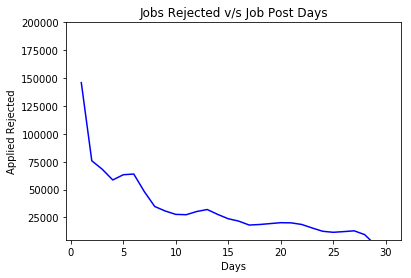

In [6]:
import matplotlib.pyplot as plt

plt.plot(days, jobRejected, color = 'b')
plt.ylim(5000, 200000)
plt.xlabel('Days')
plt.ylabel('Applied Rejected')
plt.title('Jobs Rejected v/s Job Post Days')
plt.show()


In [7]:
data.columns

Index(['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'job_age_days', 'apply', 'search_date_pacific', 'u_id', 'mgoc_id',
       'city_match_0.0', 'city_match_1.0'],
      dtype='object')

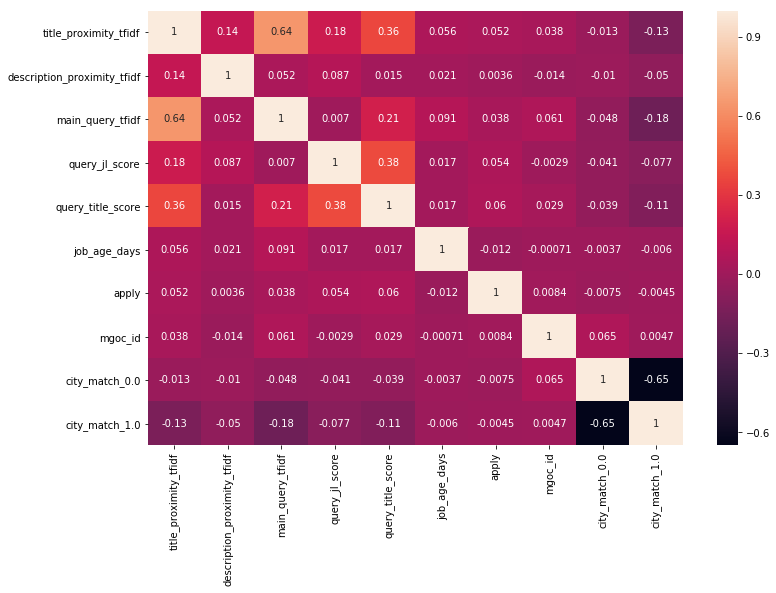

In [8]:
# check scatter matrix analysis
import seaborn as sns
plt.figure(figsize=(12, 8))

vg_corr = data_train.corr()
sns.heatmap(vg_corr, 
            xticklabels = vg_corr.columns.values,
            yticklabels = vg_corr.columns.values,
            annot = True);
plt.show()

In [9]:
# bivariate city match v/s apply
pd.crosstab(index=data_train['city_match_1.0'],columns=data_train['apply'])

apply,0,1
city_match_1.0,,
0,546337,54689
1,440610,42728


In [10]:
data_train['job_age_days'].describe().apply(lambda x: format(x, 'f'))

# 75% percentile is at 14, so job post older than 14

count    1084364.000000
mean          10.136715
std           17.112076
min            0.000000
25%            2.000000
50%            6.000000
75%           14.000000
max         1340.000000
Name: job_age_days, dtype: object

In [11]:
data_train.columns

Index(['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'job_age_days', 'apply', 'search_date_pacific', 'u_id', 'mgoc_id',
       'city_match_0.0', 'city_match_1.0'],
      dtype='object')

In [12]:
print('Train Data')
print(data_train['apply'].value_counts())
print('Test Data')
print(data_test['apply'].value_counts())

Train Data
0    986947
1     97417
Name: apply, dtype: int64
Test Data
0    105940
1     10586
Name: apply, dtype: int64


In [13]:
## Try Class Balancing techniques

from sklearn.utils import resample

data_apply0 = data_train[data_train['apply'] == 0]
data_apply1 = data_train[data_train['apply'] == 1]

## 1. Over sample minority
#data_oversample=resample(data_apply1,replace=True,n_samples=len(data_apply0),random_state=10)
#data_train=pd.concat([data_oversample,data_apply0],axis=0)

## 2.  Under sample Majority
data_undersample = resample(data_apply0, replace = True, n_samples = len(data_apply1), random_state = 10)
data_train = pd.concat([data_undersample, data_apply1], axis = 0)

## 3. Oversampling by SMOTE 
# from imblearn.over_sampling import SMOTE 

# x_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
#        'main_query_tfidf', 'query_jl_score', 'query_title_score',
#        'city_match_0.0','city_match_1.0', 'job_age_days']

# y_features = ['apply']

# sm = SMOTE(random_state = 10)
# X_res, y_res = sm.fit_sample(data_train[x_features], data_train[y_features].values.ravel())

# print('SMOTE-d Shape..')
# print(np.bincount(y_res))

# x_train = pd.DataFrame(X_res, columns = x_features)
# y_train = pd.DataFrame(y_res, columns = y_features)
# data_train = pd.concat([x_train,y_train], axis=1)


In [14]:
# After balancing the class - under sample the majority
print(data_train['apply'].value_counts())

1    97417
0    97417
Name: apply, dtype: int64


In [15]:
print(data_train.head())

         title_proximity_tfidf  description_proximity_tfidf  main_query_tfidf  \
420280                     0.0                     0.000000          1.444270   
925850                     0.0                     0.279893          0.000000   
1072328                    0.0                     0.000000          9.060391   
540093                     0.0                     0.000000          0.000000   
751875                     0.0                     0.000000          2.945106   

         query_jl_score  query_title_score  job_age_days  apply  \
420280         0.000001           0.000001          11.0      0   
925850         0.012250           0.010777           1.0      0   
1072328        0.012048           0.010809          20.0      0   
540093         0.015903           0.016127           4.0      0   
751875         0.023813           0.025633           6.0      0   

        search_date_pacific                                  u_id  mgoc_id  \
420280           2018-01-23  5b5

In [16]:
## Get Important Features using RF

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

x_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features = ['apply']

forest = RandomForestClassifier(n_estimators = 20)
forest.fit(data_train[x_features], data_train[y_features].values.ravel())

#y_pred=forest.predict_proba(data_test[x_features])
importances = forest.feature_importances_


std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data_train[x_features].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

print(sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), x_features), 
             reverse=True))

#print(roc_auc_score(data_test[y_features],y_pred))

Feature ranking:
1. feature 4 (0.299096)
2. feature 3 (0.255010)
3. feature 2 (0.163502)
4. feature 7 (0.110839)
5. feature 1 (0.091084)
6. feature 0 (0.063724)
7. feature 6 (0.008385)
8. feature 5 (0.008360)
[(0.29909999999999998, 'query_title_score'), (0.255, 'query_jl_score'), (0.16350000000000001, 'main_query_tfidf'), (0.1108, 'job_age_days'), (0.0911, 'description_proximity_tfidf'), (0.063700000000000007, 'title_proximity_tfidf'), (0.0083999999999999995, 'city_match_1.0'), (0.0083999999999999995, 'city_match_0.0')]


In [17]:
## Model evaluation for probability based models
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

def ModelEvaluation(modelname,data_test,y_pred,y_pred_prob):
    metric_auc=roc_auc_score(data_test[y_features],y_pred)
    print(classification_report(data_test[y_features], y_pred))
    c_matrix = confusion_matrix(data_test[y_features], y_pred)
    print('Printing Confusion Matrix...')
    print(c_matrix)

    fpr, tpr, thresholds = roc_curve(np.array(data_test[y_features]), y_pred_prob)
    
    AUC_score=metrics.auc(fpr, tpr)
    print('AUC Score..')
    print(AUC_score)
    plt.figure()
    plt.plot(fpr, tpr, label=modelname+' (area = %0.2f)' % AUC_score)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC')
    plt.legend(loc="lower right")
    plt.show()

             precision    recall  f1-score   support

          0       0.92      0.55      0.69    105940
          1       0.10      0.49      0.16     10586

avg / total       0.84      0.55      0.64    116526

Printing Confusion Matrix...
[[58482 47458]
 [ 5431  5155]]
AUC Score..
0.521551621872


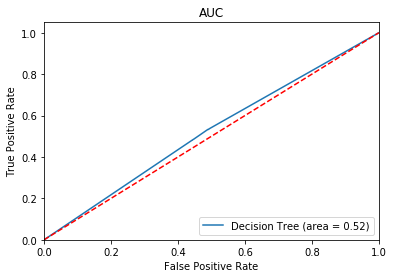

In [19]:
from sklearn import tree

modelname='Decision Tree'

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features=['apply']

#dt = tree.DecisionTreeClassifier(criterion='gini')
## AUC Score 0.51
dt = tree.DecisionTreeClassifier(criterion = 'entropy')

dt.fit(data_train[x_features], data_train[y_features].values.ravel()) 
y_pred = dt.predict(data_test[x_features])
y_pred_prob=dt.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.92      0.53      0.68    105940
          1       0.11      0.56      0.18     10586

avg / total       0.85      0.54      0.63    116526

Printing Confusion Matrix...
[[56466 49474]
 [ 4636  5950]]
AUC Score..
0.568151030115


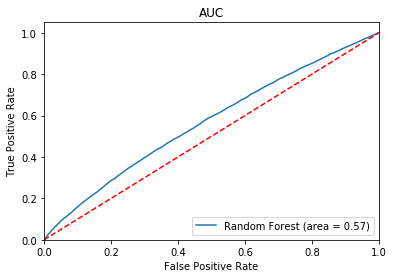

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

modelname = 'Random Forest'
x_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features = ['apply']

forest = RandomForestClassifier(n_estimators = 100)
forest.fit(data_train[x_features], data_train[y_features].values.ravel())
y_pred = forest.predict(data_test[x_features])
y_pred_prob = forest.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname, data_test, y_pred, y_pred_prob)

             precision    recall  f1-score   support

          0       0.92      0.67      0.77    105940
          1       0.12      0.46      0.19     10586

avg / total       0.85      0.65      0.72    116526

Printing Confusion Matrix...
[[70659 35281]
 [ 5769  4817]]
AUC Score..
0.588382011056


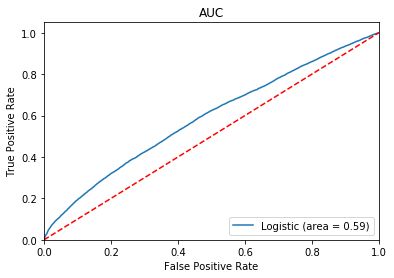

In [18]:
## Under Sampled Data with Logistic
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

modelname='Logistic'
logreg = LogisticRegression(random_state = 10)

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

X_imp_features = ['query_jl_score', 'query_title_score', 'main_query_tfidf', 'description_proximity_tfidf', 'job_age_days', 'title_proximity_tfidf']

y_features = ['apply']

forest = logreg.fit(data_train[X_imp_features], data_train[y_features].values.ravel())
y_pred=forest.predict(data_test[X_imp_features])
y_pred_prob = forest.predict_proba(data_test[X_imp_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.93      0.58      0.71    105940
          1       0.12      0.57      0.20     10586

avg / total       0.86      0.58      0.67    116526

Printing Confusion Matrix...
[[61079 44861]
 [ 4539  6047]]
AUC Score..
0.604531912913


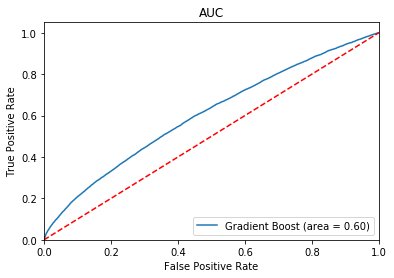

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

grd = GradientBoostingClassifier(learning_rate = 0.2, min_samples_split = 500, random_state = 10, n_estimators = 50)

modelname = 'Gradient Boost'

grd.fit(data_train[x_features], data_train[y_features].values.ravel()) 
y_pred = grd.predict(data_test[x_features])
y_pred_prob=grd.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


             precision    recall  f1-score   support

          0       0.93      0.58      0.71    105940
          1       0.12      0.57      0.20     10586

avg / total       0.86      0.58      0.67    116526

Printing Confusion Matrix...
[[61200 44740]
 [ 4592  5994]]
AUC Score..
0.600671923205


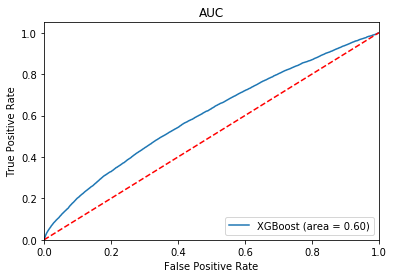

In [23]:
import xgboost as xgb


modelname = 'XGBoost'
x_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features = ['apply']

gbm = xgb.XGBClassifier(max_depth = 3, n_estimators = 300, learning_rate = 0.25)
gbm.fit(data_train[x_features], data_train[y_features].values.ravel())
y_pred = gbm.predict(data_test[x_features])
y_pred_prob = gbm.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname, data_test, y_pred, y_pred_prob)

In [ ]:
from sklearn import svm

modelname='SVM'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features=['apply']
vm = svm.SVC(kernel='linear')

vm.fit(data_train[x_features], data_train[y_features]) 
y_pred = vm.predict(data_test[x_features])
y_pred_prob=vm.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       0.92      0.77      0.84    105940
          1       0.13      0.34      0.19     10586

avg / total       0.85      0.73      0.78    116526

Printing Confusion Matrix...
[[81597 24343]
 [ 6950  3636]]
AUC Score..
0.579506867456


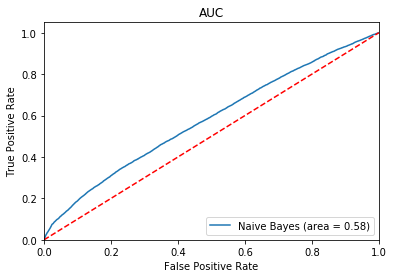

In [24]:
from sklearn.naive_bayes import GaussianNB
modelname='Naive Bayes'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features=['apply']

nb = GaussianNB()

nb.fit(data_train[x_features], data_train[y_features]) 
y_pred = nb.predict(data_test[x_features])
y_pred_prob=nb.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)